In [1]:
pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


In [2]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import os
import glob
import random
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import BatchNormalization, Activation # ⭐️ 5차 시도 변경점 1: BN, Activation import
# Grad-CAM 및 시각화를 위한 추가 라이브러리 import
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import tensorflow.keras.backend as K
import cv2 

print(tf.__version__)
print(np.__version__)
print("PIL 라이브러리 import 완료!")

2.6.0
1.22.2
PIL 라이브러리 import 완료!


In [3]:
def set_deterministic_mode(seed_value):
    # 1. 파이썬, NumPy, TensorFlow의 난수 시드 고정
    os.environ['PYTHONHASHSEED'] = str(seed_value)
    tf.random.set_seed(seed_value)
    np.random.seed(seed_value)
    random.seed(seed_value)
    
    # 2. GPU 결정성 모드 강제 설정 (학습 속도 저하 가능성 있음)
    os.environ['TF_DETERMINISTIC_OPS'] = '1' 
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

# 시드 값 설정 및 함수 호출
SEED = 42
set_deterministic_mode(SEED)

In [4]:
def resize_images(img_path):
	images=glob.glob(img_path + "/*.jpg")
	print(len(images), " images to be resized.")

	target_size=(28,28)
	for img in images:
		old_img=Image.open(img)
		new_img=old_img.resize(target_size, Image.LANCZOS)
		new_img.save(img, "JPEG")

	print(len(images), " images resized.")

# 모든 이미지 리사이즈 (가정: 훈련 데이터 경로)
image_dir_path_train_base = os.getenv("HOME") + "/aiffel/rock_scissor_paper"
resize_images(image_dir_path_train_base + "/scissor")
resize_images(image_dir_path_train_base + "/rock")
resize_images(image_dir_path_train_base + "/paper")
print("훈련 이미지 resize 완료!")

100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
훈련 이미지 resize 완료!


In [5]:
# ⭐️ Gray Scale (1채널) 로드 함수 유지 ⭐️
def load_data(img_path, number_of_data):  
	img_size=28
	color=1 # 컬러 채널 수 3 -> 1로 변경 (Gray Scale)
	
	imgs=np.zeros(number_of_data*img_size*img_size*color,dtype=np.int32).reshape(number_of_data,img_size,img_size,color)
	labels=np.zeros(number_of_data,dtype=np.int32)

	idx=0
	for file in glob.iglob(img_path+'/*/*.jpg'):
		if idx == number_of_data: break
		
		# Image.open().convert('L')을 사용하여 흑백으로 변환
		img = np.array(Image.open(file).convert('L'),dtype=np.int32)
		
		imgs[idx,:,:,:]=img.reshape(img_size, img_size, color)
		
		if 'scissor' in file:
			labels[idx]=0
		elif 'rock' in file:
			labels[idx]=1
		elif 'paper' in file:
			labels[idx]=2
			
		idx=idx+1

	print("로드된 이미지 개수는", idx,"입니다.")
	return imgs[:idx], labels[:idx]

In [6]:
TRAIN_DATA_COUNT = 300
image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper"
(x_train_raw, y_train)=load_data(image_dir_path, number_of_data=TRAIN_DATA_COUNT)
x_train = x_train_raw/255.0

print("\n--- 훈련 데이터 정보 (5차 시도: Gray Scale) ---")
print("x_train shape: {}".format(x_train.shape))
print("y_train shape: {}".format(y_train.shape))

로드된 이미지 개수는 300 입니다.

--- 훈련 데이터 정보 (5차 시도: Gray Scale) ---
x_train shape: (300, 28, 28, 1)
y_train shape: (300,)


라벨:  0


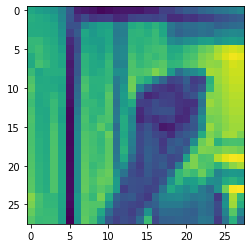

In [7]:
plt.imshow(x_train[0])
print('라벨: ', y_train[0])

In [8]:
n_channel_1=32
n_channel_2=64
n_dense=128
n_train_epoch=20

model=keras.models.Sequential()

# ⭐️ 5차 시도 변경점 2: Batch Normalization 추가 ⭐️

# 1. Conv1 레이어
model.add(keras.layers.Conv2D(n_channel_1, (3,3), use_bias=False, input_shape=(28,28,1))) # bias를 BN에 위임
model.add(BatchNormalization()) # BN 추가
model.add(Activation('relu'))   # BN 후 Relu
model.add(keras.layers.MaxPool2D((2,2)))

# 2. Conv2 레이어
model.add(keras.layers.Conv2D(n_channel_2, (3,3), use_bias=False, name='last_conv_layer')) 
model.add(BatchNormalization()) # BN 추가
model.add(Activation('relu'))   # BN 후 Relu
model.add(keras.layers.MaxPooling2D((2,2)))

model.add(keras.layers.Flatten())
model.add(keras.layers.Dropout(0.25))

# 3. Dense1 레이어
model.add(keras.layers.Dense(n_dense, use_bias=False)) 
model.add(BatchNormalization()) # BN 추가
model.add(Activation('relu'))   # BN 후 Relu

model.add(keras.layers.Dropout(0.25))
# 4. 출력 레이어 (활성화 함수 유지)
model.add(keras.layers.Dense(3, activation='softmax'))

print("\n--- 모델 구조 (5차 시도: Gray Scale + Batch Normalization) ---")
model.summary()


--- 모델 구조 (5차 시도: Gray Scale + Batch Normalization) ---
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        288       
_________________________________________________________________
batch_normalization (BatchNo (None, 26, 26, 32)        128       
_________________________________________________________________
activation (Activation)      (None, 26, 26, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
last_conv_layer (Conv2D)     (None, 11, 11, 64)        18432     
_________________________________________________________________
batch_normalization_1 (Batch (None, 11, 11, 64)        256       
_________________________________________________________________

In [9]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

datagen = ImageDataGenerator(
    rotation_range=15, zoom_range=0.1, width_shift_range=0.1,
    height_shift_range=0.1, horizontal_flip=True, fill_mode='nearest'
)

BATCH_SIZE = 32
TRAIN_DATA_COUNT_ADJUSTED = x_train.shape[0]

print("\n--- 모델 훈련 (5차 시도: Batch Normalization 적용) ---")
history = model.fit(
    datagen.flow(x_train, y_train, batch_size=BATCH_SIZE, shuffle=False),
    epochs=n_train_epoch,
    steps_per_epoch=int(np.ceil(TRAIN_DATA_COUNT_ADJUSTED / BATCH_SIZE))
)


--- 모델 훈련 (5차 시도: Batch Normalization 적용) ---
Epoch 1/20
10/10 [==============================] - 2s 64ms/step - loss: 0.7112 - accuracy: 0.6433
Epoch 2/20
10/10 [==============================] - 1s 61ms/step - loss: 0.3535 - accuracy: 0.9067
Epoch 3/20
10/10 [==============================] - 1s 69ms/step - loss: 0.1548 - accuracy: 0.9933
Epoch 4/20
10/10 [==============================] - 1s 62ms/step - loss: 0.0922 - accuracy: 0.9967
Epoch 5/20
10/10 [==============================] - 1s 66ms/step - loss: 0.0476 - accuracy: 1.0000
Epoch 6/20
10/10 [==============================] - 1s 61ms/step - loss: 0.0364 - accuracy: 1.0000
Epoch 7/20
10/10 [==============================] - 1s 72ms/step - loss: 0.0268 - accuracy: 1.0000
Epoch 8/20
10/10 [==============================] - 1s 63ms/step - loss: 0.0242 - accuracy: 1.0000
Epoch 9/20
10/10 [==============================] - 1s 63ms/step - loss: 0.0198 - accuracy: 1.0000
Epoch 10/20
10/10 [==============================] - 1s 65ms/s

In [10]:
image_dir_path_test = os.getenv("HOME") + "/aiffel/rock_scissor_paper/test"
resize_images(image_dir_path_test + "/scissor")
resize_images(image_dir_path_test + "/rock")
resize_images(image_dir_path_test + "/paper")

TEST_DATA_COUNT = 313

(x_test_raw, y_test)=load_data(image_dir_path_test, number_of_data=TEST_DATA_COUNT)
x_test = x_test_raw/255.0

print("\n--- 테스트 데이터 정보 ---")
print("x_test shape: {}".format(x_test.shape)) 
print("y_test shape: {}".format(y_test.shape))

print("\n--- 모델 성능 평가 ---")
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=2)
print("test_loss: {} ".format(test_loss))
print("test_accuracy: {} ".format(test_accuracy))

107  images to be resized.
107  images resized.
102  images to be resized.
102  images resized.
104  images to be resized.
104  images resized.
로드된 이미지 개수는 313 입니다.

--- 테스트 데이터 정보 ---
x_test shape: (313, 28, 28, 1)
y_test shape: (313,)

--- 모델 성능 평가 ---
10/10 - 0s - loss: 0.0161 - accuracy: 1.0000
test_loss: 0.016082005575299263 
test_accuracy: 1.0 


In [11]:
## Grad-CAM 함수 구현 (유지)
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    """Grad-CAM 히트맵을 생성합니다."""
    grad_model = tf.keras.models.Model(
        [model.inputs], 
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def display_gradcam(img_path, heatmap, alpha=0.4):
    """Grad-CAM 히트맵을 원본 이미지에 겹쳐서 시각화합니다."""
    img = cv2.imread(img_path)
    img = cv2.resize(img, (28, 28)) 
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # 원본 이미지 (28, 28, 3) 

    # 히트맵을 이미지 크기에 맞게 리사이즈
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    
    # 컬러맵 적용
    jet = cm.get_cmap("jet")
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # 히트맵을 255 스케일로 변환
    jet_heatmap = np.uint8(255 * jet_heatmap)
    
    # 원본 이미지 위에 히트맵 오버레이
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = np.uint8(superimposed_img)
    
    plt.imshow(superimposed_img)
    plt.title("Grad-CAM Analysis")
    plt.axis('off')
    plt.show()


--- Grad-CAM 분석 예시 (바위) ---


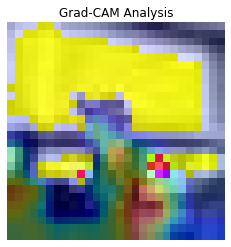


--- Grad-CAM 분석 예시 (보) ---


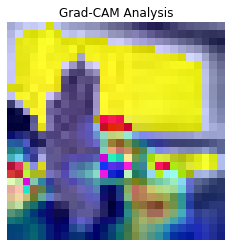


--- Grad-CAM 분석 예시 (가위) ---


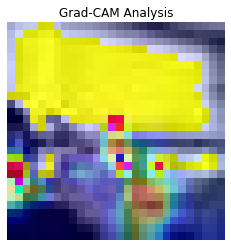

In [12]:
## Grad-CAM 실행 (클래스별 1장씩)
print("\n--- Grad-CAM 분석 예시 (바위) ---")
example_img_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/test/rock/0.jpg"
img_array = x_test[0:1] 
heatmap = make_gradcam_heatmap(img_array, model, 'last_conv_layer')
try:
    display_gradcam(example_img_path, heatmap)
except Exception as e:
    print(f"Grad-CAM 시각화 중 오류 발생: {e}. (OpenCV 및 실제 이미지 경로 확인 필요)")

print("\n--- Grad-CAM 분석 예시 (보) ---")
example_img_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/test/paper/0.jpg"
img_array = x_test[1:2] 
heatmap = make_gradcam_heatmap(img_array, model, 'last_conv_layer')
try:
    display_gradcam(example_img_path, heatmap)
except Exception as e:
    print(f"Grad-CAM 시각화 중 오류 발생: {e}. (OpenCV 및 실제 이미지 경로 확인 필요)")

print("\n--- Grad-CAM 분석 예시 (가위) ---")
example_img_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/test/scissor/0.jpg"
img_array = x_test[2:3] 
heatmap = make_gradcam_heatmap(img_array, model, 'last_conv_layer')
try:
    display_gradcam(example_img_path, heatmap)
except Exception as e:
    print(f"Grad-CAM 시각화 중 오류 발생: {e}. (OpenCV 및 실제 이미지 경로 확인 필요)")

In [14]:
## 가중치(Weights) 및 편향(Bias) 추출 (BN 적용으로 인덱스 및 get_weights 변경)
print("\n--- 가중치(Weights) 및 편향(Bias) 추출 ---")

# Conv1: model.layers[0]
conv1_layer = model.layers[0]
weights_c1 = conv1_layer.get_weights()[0] # use_bias=False이므로 weights만 가져옴
print("Conv1 레이어:")
print(f"  Weights shape (커널): {weights_c1.shape}") 

# Dense1: model.layers[10] (인덱스 수정: 7 -> 10)
dense1_layer = model.layers[10] 
weights_d1 = dense1_layer.get_weights()[0] # use_bias=False이므로 weights만 가져옴
print("Dense1 레이어:")
print(f"  Weights shape: {weights_d1.shape}")


--- 가중치(Weights) 및 편향(Bias) 추출 ---
Conv1 레이어:
  Weights shape (커널): (3, 3, 1, 32)
Dense1 레이어:
  Weights shape: (1600, 128)


In [15]:
# Conv1 가중치 통계량 출력
print("\n--- Conv1 Weights (커널 값) 통계 ---")
print(f"  Min: {np.min(weights_c1):.6f}")
print(f"  Max: {np.max(weights_c1):.6f}")
print(f"  Mean: {np.mean(weights_c1):.6f}")
print(f"  Std Dev: {np.std(weights_c1):.6f}") # ⭐️ BN 적용 후 이 값의 증가 여부 확인

print("\n--- Dense1 Weights 통계 ---")
print(f"  Min: {np.min(weights_d1):.6f}")
print(f"  Max: {np.max(weights_d1):.6f}")
print(f"  Mean: {np.mean(weights_d1):.6f}")
print(f"  Std Dev: {np.std(weights_d1):.6f}")


--- Conv1 Weights (커널 값) 통계 ---
  Min: -0.145327
  Max: 0.141129
  Mean: -0.000372
  Std Dev: 0.079409

--- Dense1 Weights 통계 ---
  Min: -0.088388
  Max: 0.089311
  Mean: -0.000190
  Std Dev: 0.034789



--- Conv1 가중치 시각화 (학습된 필터 확인) ---


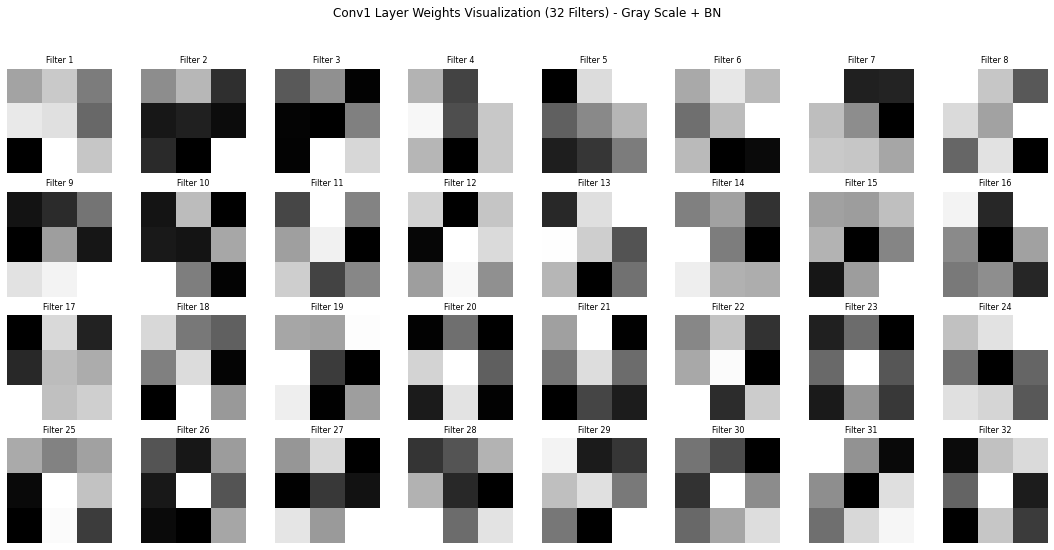

In [16]:
# Conv1 가중치 시각화 함수 (흑백 이미지에 맞춰 1채널 시각화로 변경)
def visualize_conv_weights(weights):
    # weights shape: (3, 3, 1, 32)
    
    num_filters = weights.shape[3] # 32개 필터
    fig, axes = plt.subplots(4, 8, figsize=(15, 8))
    
    for i, ax in enumerate(axes.flat):
        if i < num_filters:
            filter_weights = weights[:, :, 0, i]
            
            # 필터 내의 최솟값/최댓값을 찾아서 0~1로 스케일링
            min_val = np.min(filter_weights)
            max_val = np.max(filter_weights)
            normalized_filter = (filter_weights - min_val) / (max_val - min_val)
            
            # 흑백(Gray scale)로 시각화: cmap='gray'
            ax.imshow(normalized_filter, cmap='gray') 
            ax.set_title(f'Filter {i+1}', fontsize=8)
            ax.axis('off')
        else:
            ax.axis('off')
            
    plt.suptitle("Conv1 Layer Weights Visualization (32 Filters) - Gray Scale + BN")
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

print("\n--- Conv1 가중치 시각화 (학습된 필터 확인) ---")
visualize_conv_weights(weights_c1)


--- BN Beta (Shift, Bias 역할) 분포 분석 ---

--- Conv1 BN Beta 분포 분석 ---


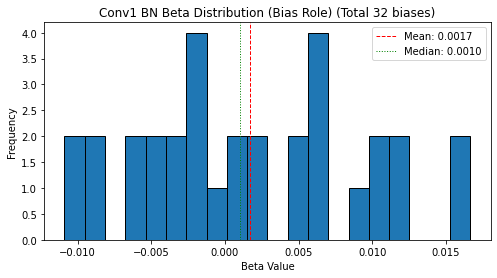


--- Dense1 BN Beta 분포 분석 ---


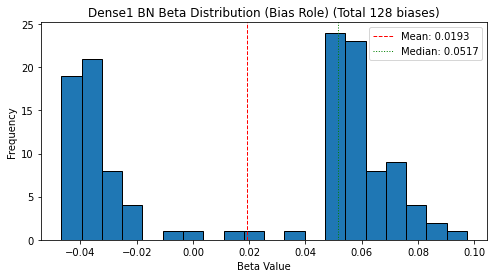

In [17]:
# 편향 값의 분포 분석 (히스토그램) - BN 적용으로 인한 편향 데이터 추출 방식 변경
# Beta (Shift parameter)가 Bias의 역할을 대신합니다.
print("\n--- BN Beta (Shift, Bias 역할) 분포 분석 ---")

# Conv1 BN 레이어: model.layers[1]
# BN의 get_weights() 출력 순서: [gamma, beta, mean, variance]
conv1_bn_layer = model.layers[1]
biases_c1_bn = conv1_bn_layer.get_weights()[1] # Beta 값 (Bias 역할)

# Dense1 BN 레이어: model.layers[11] (인덱스 수정: 8 -> 11)
dense1_bn_layer = model.layers[11]
biases_d1_bn = dense1_bn_layer.get_weights()[1] # Beta 값 (Bias 역할)

def visualize_bias_distribution(biases, layer_name):
    plt.figure(figsize=(8, 4))
    plt.hist(biases, bins=20, edgecolor='black')
    
    mean_bias = np.mean(biases)
    median_bias = np.median(biases)
    plt.axvline(mean_bias, color='r', linestyle='dashed', linewidth=1, label=f'Mean: {mean_bias:.4f}')
    plt.axvline(median_bias, color='g', linestyle='dotted', linewidth=1, label=f'Median: {median_bias:.4f}')
    
    plt.title(f'{layer_name} BN Beta Distribution (Bias Role) (Total {len(biases)} biases)')
    plt.xlabel("Beta Value")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()

print("\n--- Conv1 BN Beta 분포 분석 ---")
visualize_bias_distribution(biases_c1_bn, "Conv1")

print("\n--- Dense1 BN Beta 분포 분석 ---")
visualize_bias_distribution(biases_d1_bn, "Dense1")